# Development

All code here is experimental. Please see README for current usage instructions.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

from forecastiso.data_loader import ISODataLoader
from forecastiso.features import (
    FeatureManager,
    LagFeatureGenerator,
    RollingFeatureGenerator,
    CalendarFeatureGenerator,
    InteractionFeatureGenerator,
)
from forecastiso.forecasters import SimpleXGBForecaster, WindowedXGBForecaster

# plt.style.use("seaborn-v0_8-paper")
# plt.style.use("bmh")

In [13]:
df = pd.read_pickle("../data/caiso_hourly/preprocessed_hourly_load.pkl")
df.head()

,datetime,area,load
0,2022-01-01 00:00:00,caiso,22303.67
1,2022-01-01 01:00:00,caiso,21491.08
2,2022-01-01 02:00:00,caiso,21041.72
3,2022-01-01 03:00:00,caiso,20875.96
4,2022-01-01 04:00:00,caiso,20901.42


In [14]:
# limit to one area
df = df[df["area"] == "caiso"]
df = df.drop(columns=["area"])

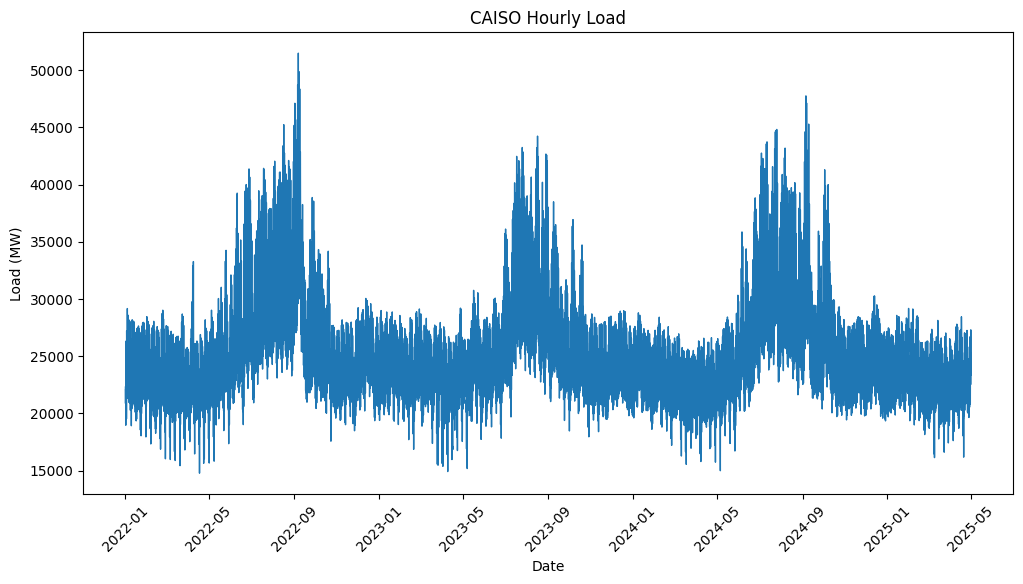

In [15]:
# line plot
plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["load"], label="Load", linewidth=1)
plt.title("CAISO Hourly Load")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.xticks(rotation=45)
plt.show()

In [16]:
# filter for a specific date range
start_date = "2022-01-01"
predict_date = "2025-02-12"
df_filtered = df[(df["datetime"] >= start_date) & (df["datetime"] < predict_date)]

ground_truth = df[df["datetime"].dt.strftime("%Y-%m-%d") == predict_date]["load"].reset_index(drop=True)

In [17]:
df_filtered.tail()

,datetime,load
27307,2025-02-11 19:00:00,27952.399986
27308,2025-02-11 20:00:00,27377.637563
27309,2025-02-11 21:00:00,26548.832918
27310,2025-02-11 22:00:00,25033.677535
27311,2025-02-11 23:00:00,23393.151125


In [18]:
# generate features

fm = FeatureManager()
fm.add_generator(LagFeatureGenerator(lags=[24, 48, 168]))
fm.add_generator(RollingFeatureGenerator(windows=[24, 168, 720]))
fm.add_generator(CalendarFeatureGenerator())
fm.add_generator(InteractionFeatureGenerator([["hour", "is_weekend"]]))
features_df = fm.generate_features(df_filtered)

print(features_df.shape)
print(features_df.columns)
print(features_df.dtypes)

(27144, 32)
Index(['load', 'load_lag_24', 'load_lag_48', 'load_lag_168',
       'load_rolling_mean_24', 'load_rolling_std_24', 'load_rolling_min_24',
       'load_rolling_max_24', 'load_rolling_mean_168', 'load_rolling_std_168',
       'load_rolling_min_168', 'load_rolling_max_168', 'load_rolling_mean_720',
       'load_rolling_std_720', 'load_rolling_min_720', 'load_rolling_max_720',
       'hour', 'dayofweek', 'month', 'day', 'quarter', 'year', 'dayofyear',
       'is_weekend', 'is_holiday', 'day_before_holiday', 'day_after_holiday',
       'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
       'hour_is_weekend'],
      dtype='object')
load                     float64
load_lag_24              float64
load_lag_48              float64
load_lag_168             float64
load_rolling_mean_24     float64
load_rolling_std_24      float64
load_rolling_min_24      float64
load_rolling_max_24      float64
load_rolling_mean_168    float64
load_rolling_std_168     float64
load_rolling_m

In [19]:
# forecaster = LinearRegressionForecaster(
#     feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
#                   "load_rolling_mean_24", "load_rolling_mean_168", "load_rolling_mean_720",
#                   "hour", "month", "dayofweek", "is_weekend", "day", "quarter", "hour_is_weekend"],
#     target_col="load",
#     standardize=False,
#     # use_ridge=True,
#     # alpha=1.0,
# )

# forecaster.fit(features_df)

# prediction = forecaster.predict(horizon=24)


In [20]:
# prediction

In [21]:
# plt.figure(figsize=(12, 6))
# plt.plot(ground_truth, label="Ground Truth", linewidth=1)
# plt.plot(prediction, label="Prediction", linewidth=1)
# plt.legend()
# plt.show()

In [22]:
forecaster = SimpleXGBForecaster(
    feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
                 "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
                 "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
                 "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
                 "hour", "month", "dayofweek", "is_holiday", "day_before_holiday", "is_weekend", "day", "quarter", "hour_is_weekend"],
    target_col="load",
)

forecaster.fit(features_df)
prediction = forecaster.predict(horizon=24)

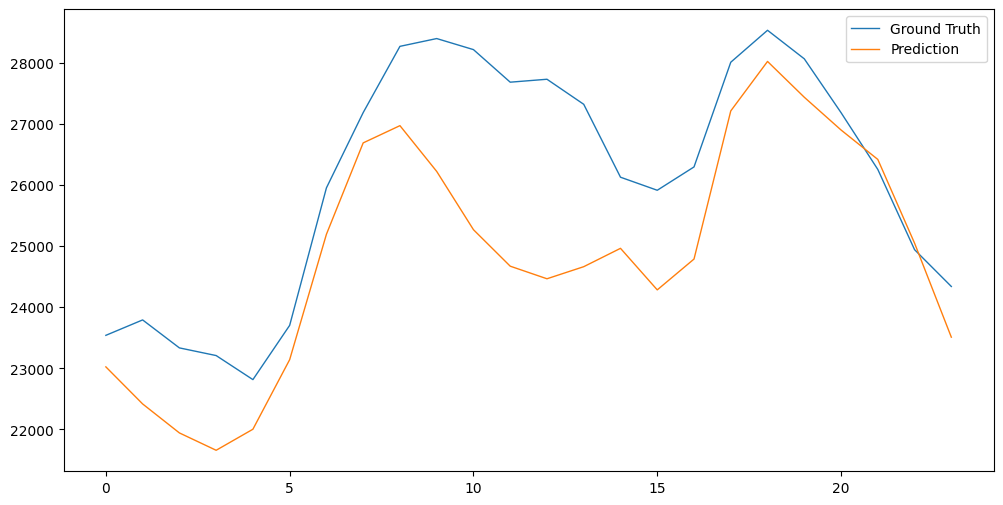

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(ground_truth, label="Ground Truth", linewidth=1)
plt.plot(prediction, label="Prediction", linewidth=1)
plt.legend()
plt.show()

In [24]:
mape = mean_absolute_percentage_error(prediction, ground_truth)
mae = mean_absolute_error(prediction, ground_truth)
rmse = root_mean_squared_error(prediction, ground_truth)

print(mape)
print(mae)
print(rmse)

0.05166213808814011
1267.1169346874954
1560.8330743508507


In [25]:
forecaster = WindowedXGBForecaster(
    target_col="load",
    feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
                   "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
                   "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
                   "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
                   "hour", "month", "dayofweek", "is_holiday", "day_before_holiday", "is_weekend", "day", "quarter", "hour_is_weekend"]
)

forecaster.fit(features_df)
prediction = forecaster.predict(horizon=24)

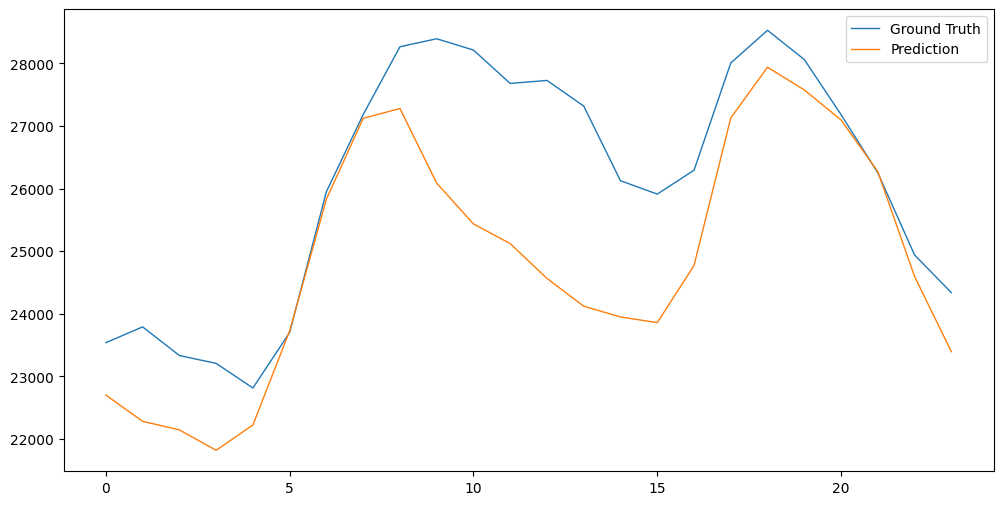

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(ground_truth, label="Ground Truth", linewidth=1)
plt.plot(prediction, label="Prediction", linewidth=1)
plt.legend()
plt.show()

In [28]:
mape = mean_absolute_percentage_error(prediction, ground_truth)
mae = mean_absolute_error(prediction, ground_truth)
rmse = root_mean_squared_error(prediction, ground_truth)

print(mape)
print(mae)
print(rmse)

0.05085094353437847
1241.313771869787
1595.0205013365342
